# Generative Adversarial Networks (GANs)
by Ian Goodfellow et al.

### Imports

In [12]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameters

In [13]:
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using {device}")

epochs = 100
batch_size = 128
lr = 2e-4
betas = (0.5, 0.999)

Using cuda


## Generator Network (G)

Input is noise, output is an MNIST digit.

In [14]:
class Generator(nn.Module):

    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()
        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape
        self.data_dim = np.prod(input_shape)
        # Define the sizes of the linear layers in the Generator:
        layer_sizes = [self.noise_dim, 256, 512, 1024]
        layers = []
        # Architecture:
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i + 1]))
            layers.append(nn.PReLU())
        # Final layer:
        layers.append(nn.Linear(in_features=layer_sizes[-1], out_features=self.data_dim))
        layers.append(nn.Tanh())
        self.generator = nn.Sequential(*layers)

    def forward(self, noise):
        noise = noise.view(-1, self.noise_dim)
        output = self.generator(noise)
        return output.view(-1, *self.data_shape)

## Discriminator Network (D)

Input is an MNIST digit (either real or fake/generated), output is a probability/score in (0,1) on whether it is fake/real.

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.data_shape = input_shape
        self.data_dim = np.prod(input_shape)
        # Define the sizes of the linear layers in the Discriminator:
        layer_sizes = [self.data_dim, 1024, 512, 256]
        layers = []
        # Discriminator architecture:
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i + 1]))
            layers.append(nn.PReLU())
            layers.append(nn.Dropout(p=0.3))
        # Final layer:
        layers.append(nn.Linear(in_features=layer_sizes[-1], out_features=1))
        layers.append(nn.Sigmoid())
        self.discriminator = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.data_dim)
        return self.discriminator(x)

## Dataset

In [16]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

## Models

In [17]:
data_shape = (1, 28, 28)
noise_dim = 128

Simple manual way to print output shapes of a model's architecture:

In [18]:
def print_dims(architecture, in_shape):
    print(f"In shape = {in_shape}")
    dummy_input = tc.randn(in_shape).to(device)
    current_output = dummy_input
    for layer in architecture:
        current_output = layer(current_output)
        print(f"Out shape after {type(layer).__name__} = {current_output.shape}")

In [19]:
gen = Generator(input_shape=data_shape, noise_shape=(noise_dim,)).to(device)
opt_gen = Adam(params=gen.parameters(), lr=lr, betas=betas)

_ = summary(model=gen, input_data=tc.zeros(size=(batch_size, noise_dim)))

print_dims(architecture=gen.generator, in_shape=(batch_size, noise_dim))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 33,024
|    └─PReLU: 2-2                        [-1, 256]                 1
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─PReLU: 2-4                        [-1, 512]                 1
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─PReLU: 2-6                        [-1, 1024]                1
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,493,523
Trainable params: 1,493,523
Non-trainable params: 0
Total mult-adds (M): 2.98
Input size (MB): 0.06
Forward/backward pass size (MB): 0.03
Params size (MB): 5.70
Estimated Total Size (MB): 5.79
In shape = (128, 128)
Out shape after Linear = torch.Size([128

In [20]:
disc = Discriminator(input_shape=data_shape).to(device)
opt_disc = Adam(params=disc.parameters(), lr=lr, betas=betas)

_ = summary(model=disc, input_data=tc.zeros(size=(batch_size, np.prod(data_shape))))

print_dims(architecture=disc.discriminator, in_shape=(batch_size, np.prod(data_shape)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─PReLU: 2-2                        [-1, 1024]                1
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─PReLU: 2-5                        [-1, 512]                 1
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─PReLU: 2-8                        [-1, 256]                 1
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,228
Trainable params: 1,460,228
Non-trainable params

## Minmax optimization

- real data $x$
- generated data $\hat{x}=G(z)$
- $D$ operates withing the range (0,1), where values closer to $1$ suggest "real" and values closer to $0$ suggest "fake".

$$
\min_{G} \max_{D} \mathbb{E}_{x\sim p_{\text{data}}}[\log(D(x))] + \mathbb{E}_{z\sim p_{\text{noise}}}[\log(1-D(G(z)))].
$$

- First term $\mathbb{E}_{x\sim p_{\text{data}}}[\log(D(x))]$ is about real samples, so maximizing this term pushes $D(x)$ towards $1$, because the logarithm function increases as its argument approaches 1.
- Second term $\mathbb{E}_{z\sim p_{\text{noise}}}[\log(1-D(G(z)))]$ is about generated samples, so maximizing this term pushes $D(G(z))$ towards $0$ because $log(1-x)$ increases as $x$ approaches $0$. On the other hand, G tries to minimize this term which would mean fooling $D$ into believing that the fakes are real, thus pushing $D(G(z))$ towards $1$.


## Loss 

Keeping in mind the above, the Discriminator loss can be:
$$
\mathcal{L}_{D} = -\sum_{i\in \text{batch}}\log(D(x_i)) - \sum_{i\in \text{batch}}\log(1-D(\hat{x}_i)) = \sum_{i\in \text{batch}}\text{BCE}(D(x_i), 1) + \sum_{i\in \text{batch}}\text{BCE}(D(\hat{x}_i), 0)
$$

So for the Generator:
$$
\mathcal{L}_{G} = \sum_{i\in \text{batch}}\text{BCE}(D(\hat{x}_i), 1)
$$

## Generation/Sampling

Feeding gaussian noise into the Generator, and the rest is plotting:

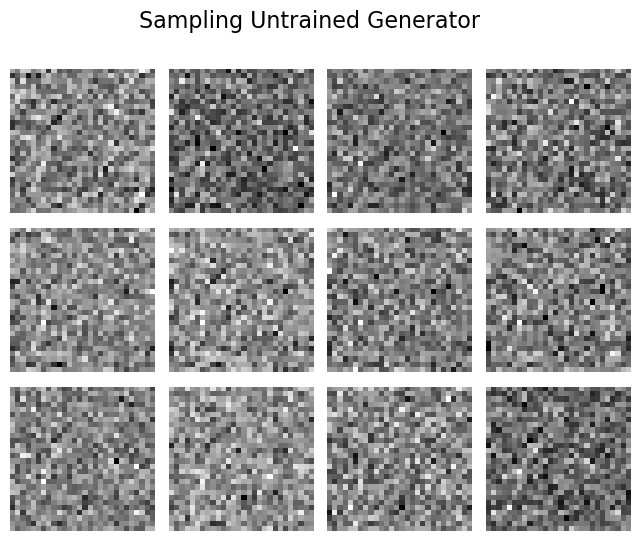

In [21]:
def generate(n_samples, title):
    z = tc.randn(n_samples, noise_dim)
    z = z.to(device)
    x_hat = gen(z)
    x_hat = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

no_samples = 12
generate(no_samples, title="Sampling Untrained Generator")

## Training

100%|██████████| 469/469 [00:16<00:00, 28.85it/s]


Epoch [1/100] | Loss D: 0.4181 | Loss G: 1.8782


100%|██████████| 469/469 [00:16<00:00, 28.49it/s]


Epoch [2/100] | Loss D: 0.3142 | Loss G: 2.7930


100%|██████████| 469/469 [00:16<00:00, 28.57it/s]


Epoch [3/100] | Loss D: 0.2005 | Loss G: 3.0759


100%|██████████| 469/469 [00:17<00:00, 27.35it/s]


Epoch [4/100] | Loss D: 0.1580 | Loss G: 3.0715


100%|██████████| 469/469 [00:16<00:00, 28.03it/s]


Epoch [5/100] | Loss D: 0.1829 | Loss G: 2.7200


100%|██████████| 469/469 [00:16<00:00, 27.62it/s]


Epoch [6/100] | Loss D: 0.1976 | Loss G: 2.5478


100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


Epoch [7/100] | Loss D: 0.2243 | Loss G: 2.4350


100%|██████████| 469/469 [00:17<00:00, 27.02it/s]


Epoch [8/100] | Loss D: 0.2770 | Loss G: 2.1786


100%|██████████| 469/469 [00:16<00:00, 29.05it/s]


Epoch [9/100] | Loss D: 0.3129 | Loss G: 1.9811


100%|██████████| 469/469 [00:16<00:00, 27.79it/s]


Epoch [10/100] | Loss D: 0.3590 | Loss G: 1.8433


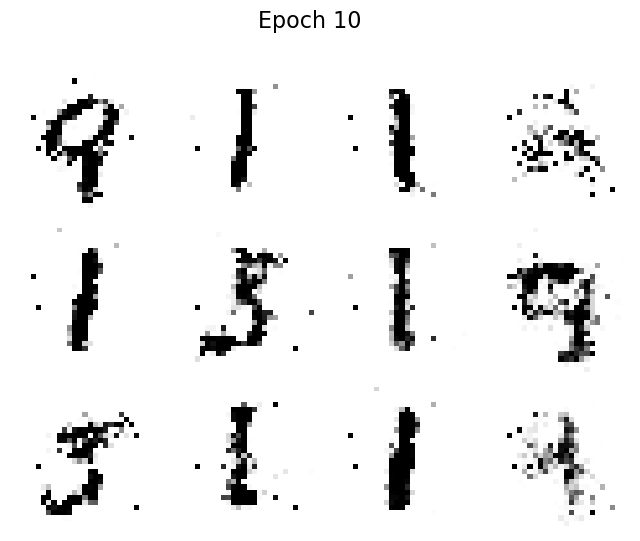

100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Epoch [11/100] | Loss D: 0.3767 | Loss G: 1.7795


100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


Epoch [12/100] | Loss D: 0.4150 | Loss G: 1.6400


100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Epoch [13/100] | Loss D: 0.4600 | Loss G: 1.5363


100%|██████████| 469/469 [00:16<00:00, 28.54it/s]


Epoch [14/100] | Loss D: 0.4699 | Loss G: 1.4184


100%|██████████| 469/469 [00:16<00:00, 28.31it/s]


Epoch [15/100] | Loss D: 0.4857 | Loss G: 1.3400


100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Epoch [16/100] | Loss D: 0.4901 | Loss G: 1.3138


100%|██████████| 469/469 [00:16<00:00, 28.46it/s]


Epoch [17/100] | Loss D: 0.4858 | Loss G: 1.3396


100%|██████████| 469/469 [00:16<00:00, 28.15it/s]


Epoch [18/100] | Loss D: 0.4833 | Loss G: 1.3334


100%|██████████| 469/469 [00:16<00:00, 28.39it/s]


Epoch [19/100] | Loss D: 0.4944 | Loss G: 1.3110


100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


Epoch [20/100] | Loss D: 0.4986 | Loss G: 1.2754


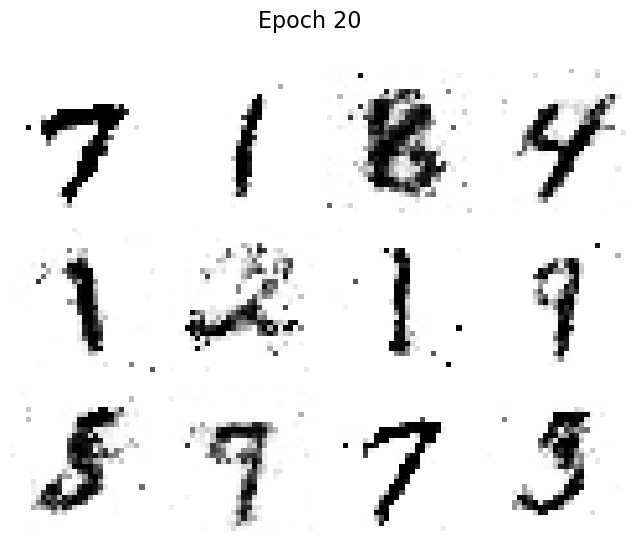

100%|██████████| 469/469 [00:16<00:00, 28.78it/s]


Epoch [21/100] | Loss D: 0.5019 | Loss G: 1.2784


100%|██████████| 469/469 [00:16<00:00, 28.57it/s]


Epoch [22/100] | Loss D: 0.5112 | Loss G: 1.2494


100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


Epoch [23/100] | Loss D: 0.5054 | Loss G: 1.2594


100%|██████████| 469/469 [00:16<00:00, 28.88it/s]


Epoch [24/100] | Loss D: 0.5088 | Loss G: 1.2662


100%|██████████| 469/469 [00:16<00:00, 29.22it/s]


Epoch [25/100] | Loss D: 0.5124 | Loss G: 1.2623


100%|██████████| 469/469 [00:16<00:00, 29.11it/s]


Epoch [26/100] | Loss D: 0.5138 | Loss G: 1.2423


100%|██████████| 469/469 [00:16<00:00, 28.75it/s]


Epoch [27/100] | Loss D: 0.5184 | Loss G: 1.2353


100%|██████████| 469/469 [00:16<00:00, 28.36it/s]


Epoch [28/100] | Loss D: 0.5131 | Loss G: 1.2468


100%|██████████| 469/469 [00:16<00:00, 28.42it/s]


Epoch [29/100] | Loss D: 0.5188 | Loss G: 1.2295


100%|██████████| 469/469 [00:16<00:00, 27.90it/s]


Epoch [30/100] | Loss D: 0.5220 | Loss G: 1.2186


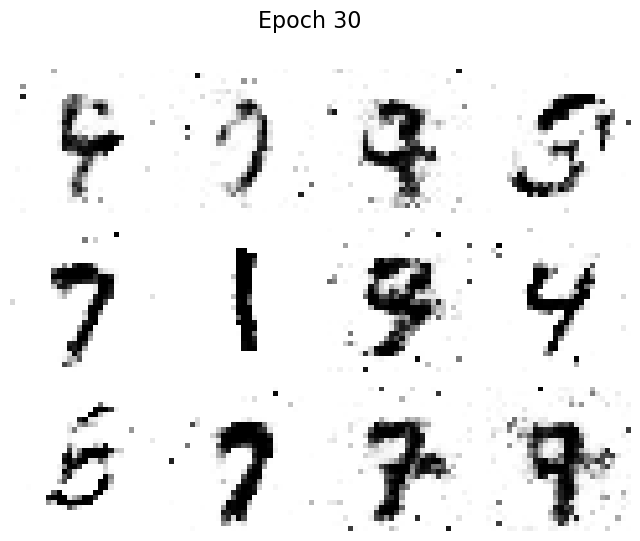

100%|██████████| 469/469 [00:16<00:00, 27.61it/s]


Epoch [31/100] | Loss D: 0.5188 | Loss G: 1.2306


100%|██████████| 469/469 [00:16<00:00, 28.08it/s]


Epoch [32/100] | Loss D: 0.5232 | Loss G: 1.2155


100%|██████████| 469/469 [00:17<00:00, 27.45it/s]


Epoch [33/100] | Loss D: 0.5239 | Loss G: 1.2196


100%|██████████| 469/469 [00:17<00:00, 26.56it/s]


Epoch [34/100] | Loss D: 0.5216 | Loss G: 1.2236


100%|██████████| 469/469 [00:16<00:00, 28.08it/s]


Epoch [35/100] | Loss D: 0.5249 | Loss G: 1.2144


100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


Epoch [36/100] | Loss D: 0.5275 | Loss G: 1.1982


100%|██████████| 469/469 [00:17<00:00, 27.11it/s]


Epoch [37/100] | Loss D: 0.5245 | Loss G: 1.2087


100%|██████████| 469/469 [00:17<00:00, 27.14it/s]


Epoch [38/100] | Loss D: 0.5285 | Loss G: 1.1917


100%|██████████| 469/469 [00:16<00:00, 27.75it/s]


Epoch [39/100] | Loss D: 0.5360 | Loss G: 1.1718


100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


Epoch [40/100] | Loss D: 0.5400 | Loss G: 1.1683


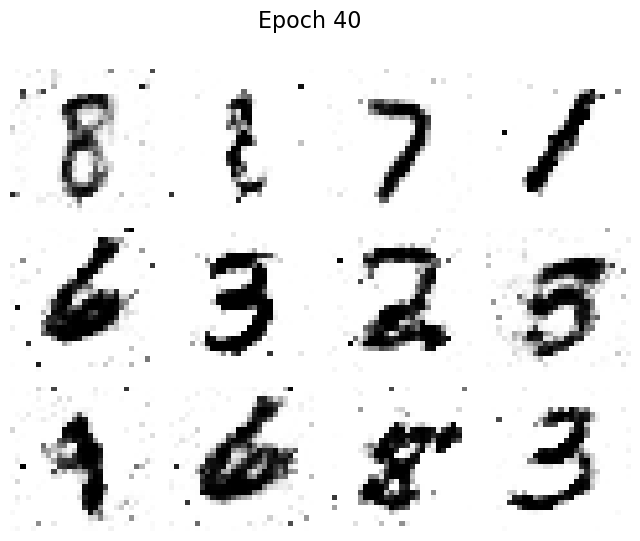

100%|██████████| 469/469 [00:17<00:00, 26.89it/s]


Epoch [41/100] | Loss D: 0.5361 | Loss G: 1.1762


100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


Epoch [42/100] | Loss D: 0.5362 | Loss G: 1.1845


100%|██████████| 469/469 [00:16<00:00, 29.21it/s]


Epoch [43/100] | Loss D: 0.5379 | Loss G: 1.1703


100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


Epoch [44/100] | Loss D: 0.5418 | Loss G: 1.1560


100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


Epoch [45/100] | Loss D: 0.5433 | Loss G: 1.1610


100%|██████████| 469/469 [00:15<00:00, 29.41it/s]


Epoch [46/100] | Loss D: 0.5374 | Loss G: 1.1751


100%|██████████| 469/469 [00:15<00:00, 29.35it/s]


Epoch [47/100] | Loss D: 0.5355 | Loss G: 1.1758


100%|██████████| 469/469 [00:16<00:00, 28.72it/s]


Epoch [48/100] | Loss D: 0.5395 | Loss G: 1.1725


100%|██████████| 469/469 [00:15<00:00, 29.31it/s]


Epoch [49/100] | Loss D: 0.5394 | Loss G: 1.1730


100%|██████████| 469/469 [00:15<00:00, 30.20it/s]


Epoch [50/100] | Loss D: 0.5398 | Loss G: 1.1661


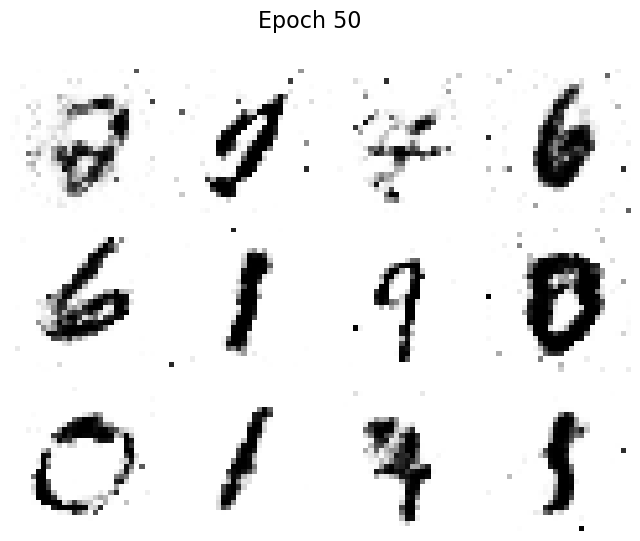

100%|██████████| 469/469 [00:14<00:00, 31.75it/s]


Epoch [51/100] | Loss D: 0.5360 | Loss G: 1.1795


100%|██████████| 469/469 [00:14<00:00, 31.92it/s]


Epoch [52/100] | Loss D: 0.5375 | Loss G: 1.1718


100%|██████████| 469/469 [00:14<00:00, 32.05it/s]


Epoch [53/100] | Loss D: 0.5354 | Loss G: 1.1779


100%|██████████| 469/469 [00:14<00:00, 32.52it/s]


Epoch [54/100] | Loss D: 0.5359 | Loss G: 1.1709


100%|██████████| 469/469 [00:14<00:00, 32.81it/s]


Epoch [55/100] | Loss D: 0.5351 | Loss G: 1.1705


100%|██████████| 469/469 [00:14<00:00, 32.30it/s]


Epoch [56/100] | Loss D: 0.5338 | Loss G: 1.1745


100%|██████████| 469/469 [00:14<00:00, 31.35it/s]


Epoch [57/100] | Loss D: 0.5382 | Loss G: 1.1721


100%|██████████| 469/469 [00:14<00:00, 31.36it/s]


Epoch [58/100] | Loss D: 0.5362 | Loss G: 1.1793


100%|██████████| 469/469 [00:14<00:00, 32.22it/s]


Epoch [59/100] | Loss D: 0.5383 | Loss G: 1.1664


100%|██████████| 469/469 [00:14<00:00, 32.44it/s]


Epoch [60/100] | Loss D: 0.5364 | Loss G: 1.1750


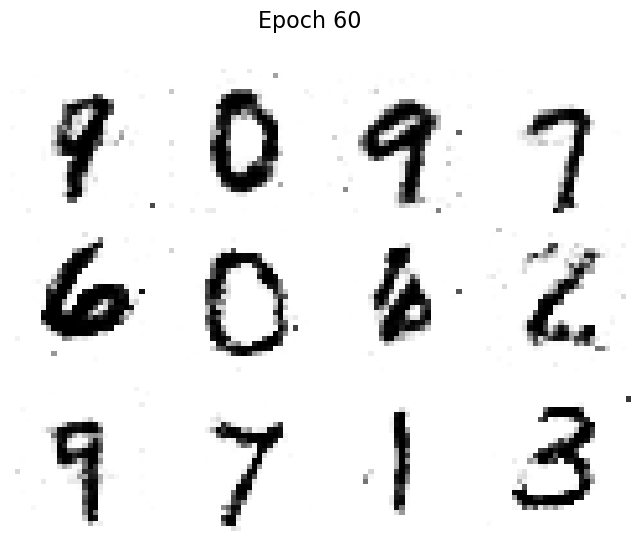

100%|██████████| 469/469 [00:14<00:00, 32.56it/s]


Epoch [61/100] | Loss D: 0.5353 | Loss G: 1.1766


100%|██████████| 469/469 [00:14<00:00, 32.86it/s]


Epoch [62/100] | Loss D: 0.5420 | Loss G: 1.1592


100%|██████████| 469/469 [00:14<00:00, 32.85it/s]


Epoch [63/100] | Loss D: 0.5389 | Loss G: 1.1708


100%|██████████| 469/469 [00:14<00:00, 32.76it/s]


Epoch [64/100] | Loss D: 0.5387 | Loss G: 1.1595


100%|██████████| 469/469 [00:14<00:00, 31.79it/s]


Epoch [65/100] | Loss D: 0.5390 | Loss G: 1.1615


100%|██████████| 469/469 [00:14<00:00, 31.44it/s]


Epoch [66/100] | Loss D: 0.5404 | Loss G: 1.1676


100%|██████████| 469/469 [00:14<00:00, 31.28it/s]


Epoch [67/100] | Loss D: 0.5386 | Loss G: 1.1682


100%|██████████| 469/469 [00:14<00:00, 31.43it/s]


Epoch [68/100] | Loss D: 0.5428 | Loss G: 1.1560


100%|██████████| 469/469 [00:14<00:00, 31.90it/s]


Epoch [69/100] | Loss D: 0.5431 | Loss G: 1.1521


100%|██████████| 469/469 [00:14<00:00, 31.80it/s]


Epoch [70/100] | Loss D: 0.5403 | Loss G: 1.1659


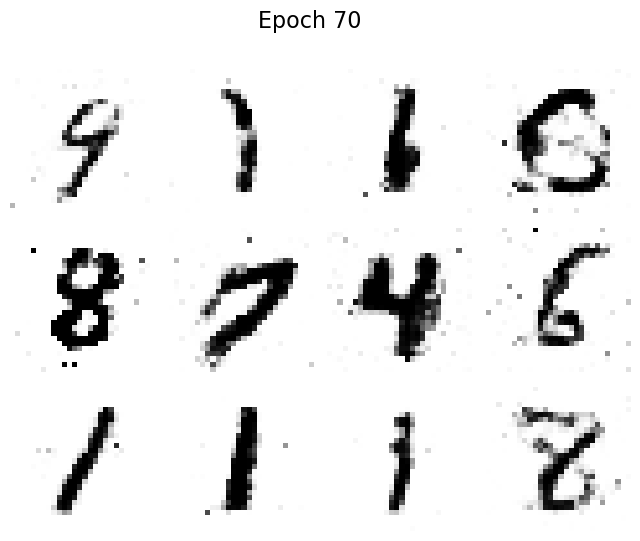

100%|██████████| 469/469 [00:14<00:00, 31.78it/s]


Epoch [71/100] | Loss D: 0.5383 | Loss G: 1.1664


100%|██████████| 469/469 [00:15<00:00, 31.08it/s]


Epoch [72/100] | Loss D: 0.5416 | Loss G: 1.1491


100%|██████████| 469/469 [00:14<00:00, 31.97it/s]


Epoch [73/100] | Loss D: 0.5415 | Loss G: 1.1598


100%|██████████| 469/469 [00:14<00:00, 31.63it/s]


Epoch [74/100] | Loss D: 0.5390 | Loss G: 1.1621


100%|██████████| 469/469 [00:15<00:00, 31.26it/s]


Epoch [75/100] | Loss D: 0.5402 | Loss G: 1.1623


100%|██████████| 469/469 [00:14<00:00, 31.87it/s]


Epoch [76/100] | Loss D: 0.5386 | Loss G: 1.1673


100%|██████████| 469/469 [00:14<00:00, 31.53it/s]


Epoch [77/100] | Loss D: 0.5346 | Loss G: 1.1760


100%|██████████| 469/469 [00:14<00:00, 32.19it/s]


Epoch [78/100] | Loss D: 0.5359 | Loss G: 1.1748


100%|██████████| 469/469 [00:14<00:00, 32.65it/s]


Epoch [79/100] | Loss D: 0.5356 | Loss G: 1.1644


100%|██████████| 469/469 [00:14<00:00, 31.98it/s]


Epoch [80/100] | Loss D: 0.5347 | Loss G: 1.1787


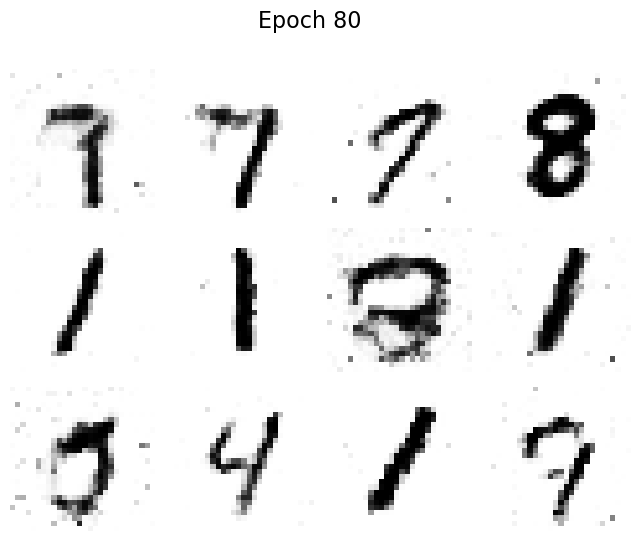

100%|██████████| 469/469 [00:14<00:00, 31.41it/s]


Epoch [81/100] | Loss D: 0.5388 | Loss G: 1.1676


100%|██████████| 469/469 [00:14<00:00, 31.34it/s]


Epoch [82/100] | Loss D: 0.5359 | Loss G: 1.1743


100%|██████████| 469/469 [00:15<00:00, 30.38it/s]


Epoch [83/100] | Loss D: 0.5356 | Loss G: 1.1784


100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


Epoch [84/100] | Loss D: 0.5333 | Loss G: 1.1790


100%|██████████| 469/469 [00:15<00:00, 31.06it/s]


Epoch [85/100] | Loss D: 0.5336 | Loss G: 1.1828


100%|██████████| 469/469 [00:15<00:00, 31.06it/s]


Epoch [86/100] | Loss D: 0.5346 | Loss G: 1.1777


100%|██████████| 469/469 [00:15<00:00, 30.84it/s]


Epoch [87/100] | Loss D: 0.5356 | Loss G: 1.1725


100%|██████████| 469/469 [00:14<00:00, 32.30it/s]


Epoch [88/100] | Loss D: 0.5331 | Loss G: 1.1857


100%|██████████| 469/469 [00:14<00:00, 32.29it/s]


Epoch [89/100] | Loss D: 0.5325 | Loss G: 1.1817


100%|██████████| 469/469 [00:14<00:00, 31.57it/s]


Epoch [90/100] | Loss D: 0.5324 | Loss G: 1.1824


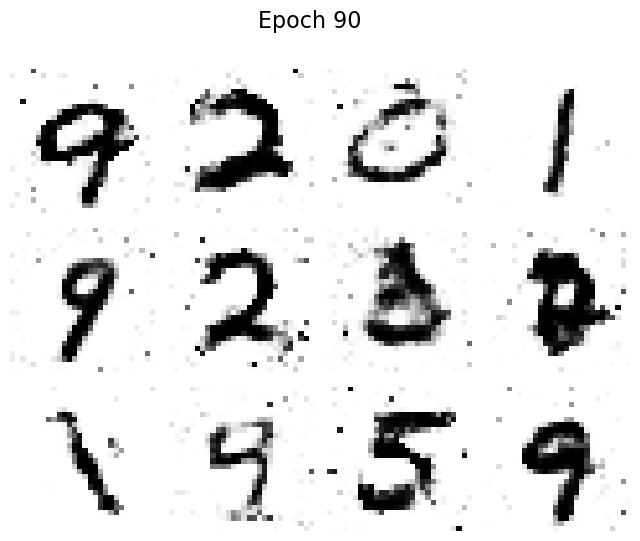

100%|██████████| 469/469 [00:14<00:00, 31.33it/s]


Epoch [91/100] | Loss D: 0.5339 | Loss G: 1.1768


100%|██████████| 469/469 [00:14<00:00, 32.15it/s]


Epoch [92/100] | Loss D: 0.5329 | Loss G: 1.1775


100%|██████████| 469/469 [00:14<00:00, 31.88it/s]


Epoch [93/100] | Loss D: 0.5333 | Loss G: 1.1796


100%|██████████| 469/469 [00:14<00:00, 31.92it/s]


Epoch [94/100] | Loss D: 0.5330 | Loss G: 1.1854


100%|██████████| 469/469 [00:15<00:00, 31.21it/s]


Epoch [95/100] | Loss D: 0.5351 | Loss G: 1.1784


100%|██████████| 469/469 [00:14<00:00, 31.41it/s]


Epoch [96/100] | Loss D: 0.5304 | Loss G: 1.1913


100%|██████████| 469/469 [00:14<00:00, 31.64it/s]


Epoch [97/100] | Loss D: 0.5267 | Loss G: 1.2059


100%|██████████| 469/469 [00:14<00:00, 32.46it/s]


Epoch [98/100] | Loss D: 0.5295 | Loss G: 1.1853


100%|██████████| 469/469 [00:14<00:00, 31.89it/s]


Epoch [99/100] | Loss D: 0.5332 | Loss G: 1.1774


100%|██████████| 469/469 [00:14<00:00, 31.81it/s]


Epoch [100/100] | Loss D: 0.5321 | Loss G: 1.1815


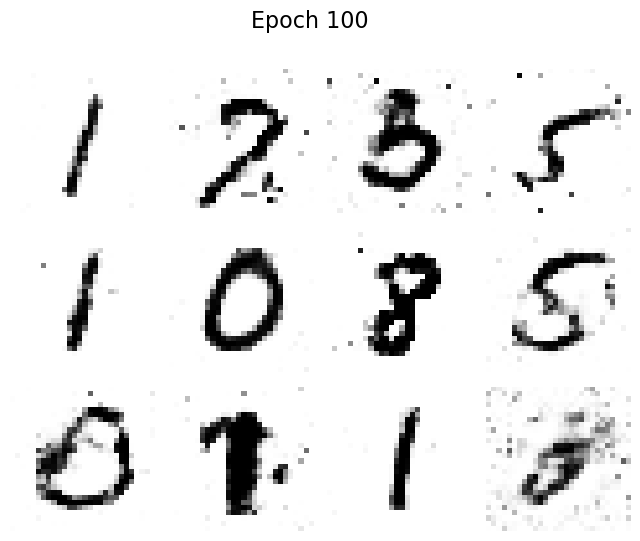

In [22]:
def train_loop():

    loss_fn = nn.BCELoss()

    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    sample_every = 10
    gen.train()
    disc.train()

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            # zero gradients:
            opt_disc.zero_grad()
            # move batch to device
            x = x.to(device)
            # create noise:
            z = tc.randn(x.shape[0], noise_dim)
            z = z.to(device)
            # call G with noise:
            x_hat = gen(z)
            # D predicts 1 for real samples:
            target_real = tc.ones((x.shape[0], 1)).to(device)
            # D predicts 0 for fake samples:
            target_fake = tc.zeros((x.shape[0], 1)).to(device)
            # call D with real input:
            pred_real = disc(x)
            # call D with fake input:
            pred_fake = disc(x_hat)
            # measure losses for both:
            loss_real = loss_fn(pred_real, target_real)
            loss_fake = loss_fn(pred_fake, target_fake)
            loss_disc = (loss_real + loss_fake) / 2
            disc_loss += loss_disc.item()
            # backpropagate on D:
            loss_disc.backward()
            # update D's weights:
            opt_disc.step()

            # ------------------------ Train Generator: ------------------------
            # create noise:
            z = tc.randn(x.shape[0], noise_dim)
            z = z.to(device)
            # call G with noise:
            x_hat = gen(z)
            # D predicts 1 for real samples:
            # target_real = tc.ones((x.shape[0], 1)).to(device)
            # call D:
            pred_fake = disc(x_hat)
            # measure G's loss:
            loss_gen = loss_fn(pred_fake, target_real)
            gen_loss += loss_gen.item()
            # zero gradients:
            gen.zero_grad()
            # backpropagate on G:
            loss_gen.backward()
            # update G's weights:
            opt_gen.step()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(no_samples, f"Epoch {epoch + 1}")
            gen.train()

    return disc_losses, gen_losses

d_loss, g_loss = train_loop()

## Plot Losses:

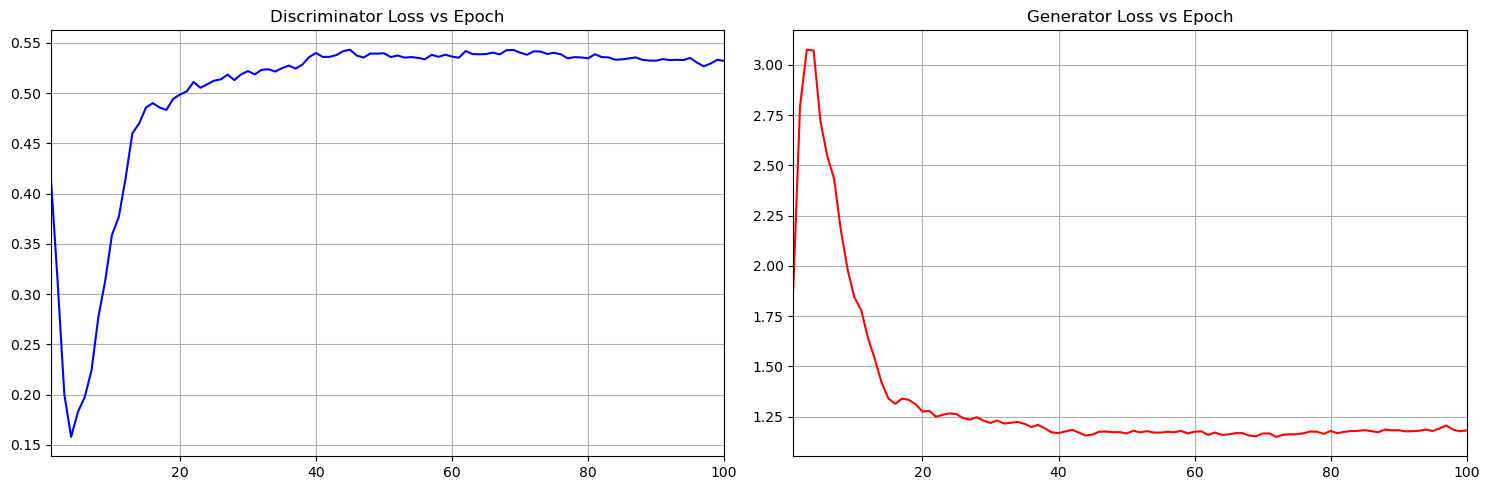

In [23]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epoch_ax, d_loss, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("Discriminator Loss vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, g_loss, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("Generator Loss vs Epoch")
ax[1].grid()

plt.tight_layout()
plt.show()
plt.close()

- Notice that when Discriminator improves, Generator gets worse and vice versa.
- Training GANs can prove hard and unstable.
- How to improve our digit generations?